# A Real Text Classification Task

## 1. Build and evaluate a basic classifier for Subtask A, adapting one of your models from Parts B and C above [10 marks].

### load datas

In [ ]:
import keras
import numpy as np
import pandas as pd

In [ ]:
# load traning and test data

### training
df_train = pd.read_csv('./olid-training-v1.0.tsv', sep='\t')
tr_tweets = df_train['tweet'].values.tolist()

### test
df_testlabels = pd.read_csv('./labels-levela.csv', header=None)
df_testset = pd.read_csv('./testset-levela.tsv', sep='\t')
test_tweets = df_testset['tweet'].values.tolist()

### Preprocessing the training corpus

In [239]:
# preprocessing the training corpus
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

# emoji pattern
emojis_pattern = re.compile("[" u"\U0001F600-\U0001F64F" u"\U0001F300-\U0001F5FF" u"\U0001F680-\U0001F6FF" u"\U0001F1E0-\U0001F1FF" u"\U00002702-\U000027B0" u"\U000024C2-\U0001F251" "]+", flags=re.UNICODE)

def preprocess_corpus(austen):
    """
    remove stop words, punctuations, '@USER' and emojis. and then convert to lowercase. 
    """
    result = []
    sws = stopwords.words('english')
    pattern = r'[!"#$%&\'()*+,-./:;<=>?@\[\\\]^_`{|}~]+'
    for row in austen:
        # to lower
        r = row.lower()
        # remove punctuations
        r = re.sub(pattern, ' ', r)
        # remove emoji
        r = emojis_pattern.sub(r' ', r)


        res = [e for e in r.split(' ') if e != '' and not e.isdigit() and e not in sws and e != "@USER"]

        result.append(' '.join(res))
    return result

normalized_train_corpus = preprocess_corpus(tr_tweets)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [240]:
print(normalized_train_corpus)

['user ask native americans take', 'user user go home you’re drunk user maga trump2020 url', 'amazon investigating chinese employees selling internal data third party sellers looking edge competitive marketplace url amazon maga kag china tcot', 'user someone vetaken piece shit volcano', 'user user obama wanted liberals amp illegals move red states', 'user liberals kookoo', 'user user oh noes tough shit', 'user literally talking lol mass shootings like set ups it’s propaganda used divide us major issues like gun control terrorism', 'user buy icecream', 'user canada doesn’t need another cuck already enough looneyleft liberals f king great country qproofs trudeaumustgo', 'user user user it’s fault support gun control', 'user what’s difference kavanaugh user one men admitted groping year old girl years ago going confirmed scj demsarefrauds demsaredone walkawaydemocrats2018 redwave voteredsaveamerica trumptrain maga url', 'user lying corrupt traitor nobody wants hear anymore lies deepstatec

### Preparing the dataset

In [ ]:
# Creating the Corpus Vocabulary and Preparing the Dataset
from keras.preprocessing import text

t = text.Tokenizer()
t.fit_on_texts(normalized_train_corpus)

# add <START>
for i in range(len(normalized_train_corpus)):
  normalized_train_corpus[i] = '<START> ' + normalized_train_corpus[i]

word2idx = t.word_index
word2idx = {k:(v+3) for k,v in word2idx.items()}
word2idx["<PAD>"] = 0
word2idx["<START>"] = 1
word2idx["<UNK>"] = 2  
word2idx["<UNUSED>"] = 3

word_ids = list(word2idx.items())


# idx2word = {}

# for k,v in word2idx.items():
#     idx2word[v] = k
  

VOCAB_SIZE = len(word_ids) + 1
EMBED_SIZE = 100
INDEX_FROM = 3

### preparing train data and labels

In [ ]:
# train data and labels
train_data = []

for sentence in normalized_train_corpus:
  r = sentence.split(' ')
  train_data.append([word2idx[ele] for ele in r])

# Offensive: 1, Not Offensive: 0
train_labels = [1 if v == 'OFF' else 0 for v in df_train['subtask_a'].values.tolist() ]


In [296]:
print(len(train_data))
print(len(train_labels))

print(train_data[0])
print(train_labels[0])

13240
13240
[1, 1, 4, 261, 2505, 192, 51]
1


In [ ]:
from keras.preprocessing.sequence import pad_sequences
MAXIMUM_LENGTH = 40

preprocessed_train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                       value=word2idx["<PAD>"],
                                                       padding='post',
                                                       maxlen=MAXIMUM_LENGTH)

In [298]:
print(preprocessed_train_data[0])

[   1    1    4  261 2505  192   51    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


### Preparing the Testset

In [ ]:
# TEST DATA
normalized_test_corpus = preprocess_corpus(test_tweets)

t = text.Tokenizer()
t.fit_on_texts(normalized_test_corpus)

# add <START>
for i in range(len(normalized_test_corpus)):
  normalized_test_corpus[i] = '<START> ' + normalized_test_corpus[i]

test_data = []

for sentence in normalized_test_corpus:
  r = sentence.split(' ')
  test_data.append([word2idx[ele] if word2idx.get(ele) else 2 for ele in r])

# TEST LABELS
# Offensive: 1, Not Offensive: 0
test_labels = [1 if v == 'OFF' else 0 for v in df_testlabels[1].values.tolist() ]

### building models : from part C

In [316]:
from keras.layers import LSTM, Embedding, Input, Dense, Dropout
from keras.models import Sequential
from keras.models import Model
units = 100

input_layer = Input(shape=(MAXIMUM_LENGTH,), dtype='int32', name='input_1')
embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAXIMUM_LENGTH, name='Embedding_Layer')(input_layer)
dropout1 = Dropout(0.2)(embedding)
lstm = LSTM(units, activation='tanh', recurrent_activation='sigmoid', name='LSTM_layer')(dropout1)
dropout2 = Dropout(0.2)(lstm)
dense = Dense(1, input_shape=(1,), activation='sigmoid', kernel_initializer='glorot_uniform', name='Output_layer')(dropout2)

model = Model(inputs=[input_layer], outputs=[dense])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40)                0         
_________________________________________________________________
Embedding_Layer (Embedding)  (None, 40, 100)           1955100   
_________________________________________________________________
dropout_9 (Dropout)          (None, 40, 100)           0         
_________________________________________________________________
LSTM_layer (LSTM)            (None, 100)               80400     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
Output_layer (Dense)         (None, 1)                 101       
Total params: 2,035,601
Trainable params: 2,035,601
Non-trainable params: 0
________________________________________________

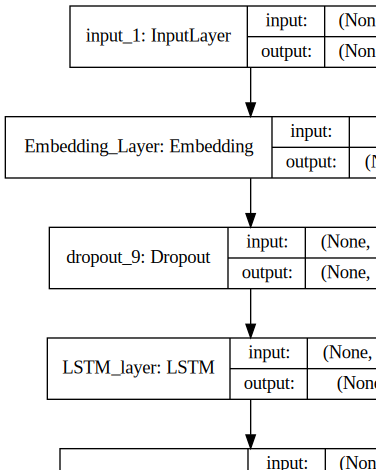

In [317]:
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

### Training the model

In [318]:
EPOCHS = 3
BATCH_SIZE = 200

x_val = np.array(preprocessed_train_data[:2000])
x_train = np.array(preprocessed_train_data[2000:])

y_val = np.array(train_labels[:2000])
y_train = np.array(train_labels[2000:])


history = model.fit(x_train, y_train, 
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_val, y_val))

Train on 11240 samples, validate on 2000 samples
Epoch 1/3
11240/11240 [==============================] - 20s 2ms/step - loss: 0.6432 - acc: 0.6673 - val_loss: 0.6391 - val_acc: 0.6630
Epoch 2/3
11240/11240 [==============================] - 15s 1ms/step - loss: 0.6271 - acc: 0.6692 - val_loss: 0.6054 - val_acc: 0.6930
Epoch 3/3
11240/11240 [==============================] - 15s 1ms/step - loss: 0.4770 - acc: 0.7930 - val_loss: 0.5451 - val_acc: 0.7485


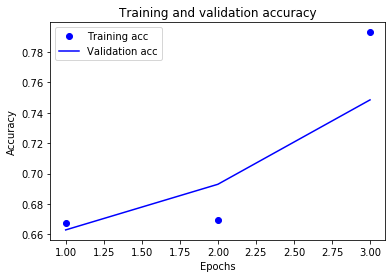

In [319]:
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Evaluating the Model on the Test Data

In [320]:
preprocessed_test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word2idx["<PAD>"],
                                                       padding='post',
                                                       maxlen=MAXIMUM_LENGTH)
results = model.evaluate(preprocessed_test_data, test_labels)
print('test_loss:', results[0], 'test_accuracy:', results[1])

860/860 [==============================] - 0s 390us/step
test_loss: 0.4848166852496391 test_accuracy: 0.7918604648390482
